<a href="https://colab.research.google.com/github/mostafa-ja/mal_adv3/blob/main/malware_cnn2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

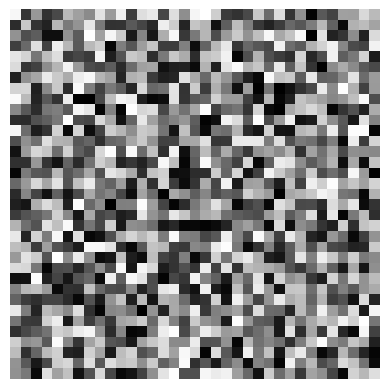

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming binary_vector is your 1D binary vector of length 10000
binary_vector = np.random.randint(2, size=9800)

# Reshape the vector into a 2D array with each element being an 8-length binary vector
image = np.reshape(binary_vector, (35, 35, 8))

# Convert binary values to gray-scale intensities
gray_image = np.packbits(image, axis=-1)

# Display the gray-scale image
plt.imshow(gray_image, cmap='gray')
plt.axis('off')
plt.show()


In [ ]:
download_links = ['https://github.com/mostafa-ja/mal_adv3/raw/main/data/X_redefined_sparse_matrix.npz',
                  'https://github.com/mostafa-ja/mal_adv3/raw/main/data/labels.pt'
]


import gdown
output_filepath = '/content/'
for link in download_links:
  gdown.download(link, output_filepath)

Downloading...
From: https://github.com/mostafa-ja/mal_adv3/raw/main/data/X_redefined_sparse_matrix.npz
To: /content/X_redefined_sparse_matrix.npz
100%|██████████| 2.31M/2.31M [00:00<00:00, 13.9MB/s]
Downloading...
From: https://github.com/mostafa-ja/mal_adv3/raw/main/data/labels.pt
To: /content/labels.pt
100%|██████████| 517k/517k [00:00<00:00, 6.80MB/s]


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from scipy import sparse
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch.nn.functional as F
import random
import time


torch.manual_seed(0)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
# Load dataset
X_redefined = sparse.load_npz("X_redefined_sparse_matrix.npz")
labels_tensor = torch.load('labels.pt')

# Split data into train, validation, and test sets with stratified sampling
X_train_val, X_test, labels_train_val, labels_test = train_test_split(X_redefined, labels_tensor, test_size=0.2, stratify=labels_tensor, random_state=42)
X_train, X_val, labels_train, labels_val = train_test_split(X_train_val, labels_train_val, test_size=0.2, stratify=labels_train_val, random_state=42)

# Combine features and labels into datasets
# we use dtype=torch.int8, for Memory-Efficient here, later we will convert to float
train_dataset = TensorDataset(torch.tensor(X_train.toarray(), dtype=torch.int8), labels_train)
val_dataset = TensorDataset(torch.tensor(X_val.toarray(), dtype=torch.int8), labels_val)
test_dataset = TensorDataset(torch.tensor(X_test.toarray(), dtype=torch.int8), labels_test)

# Clear unnecessary variables
del X_redefined, labels_tensor, X_train_val, X_test, labels_train_val, labels_test, X_train, X_val, labels_train, labels_val

In [ ]:
# Define the DataLoader for training, validation, and test sets
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
def pad_binary_vector(binary_vector, new_size):
    batch_size, vector_length = binary_vector.size()

    # Calculate the number of zeros to add
    num_zeros = new_size - vector_length

    # Create a tensor filled with zeros
    zeros_tensor = torch.zeros(batch_size, num_zeros, dtype=torch.int)

    # Concatenate the binary vector with the zeros tensor along the second dimension
    padded_binary_vector = torch.cat([binary_vector, zeros_tensor], dim=1)

    return padded_binary_vector

In [ ]:
def batch_binary_vectors_to_gray_images(binary_vectors, image_size=36):
    """
    Convert a batch of binary vectors to gray-scale images.

    Parameters:
        batch_binary_vectors (numpy.ndarray): Batch of binary vectors with shape (batch_size, vector_length).
        image_size (int): Size of the square image (default is 36).

    Returns:
        gray_images: Batch of gray-scale images with shape (batch_size, image_size, image_size).
    """
    batch_binary_vectors = pad_binary_vector(binary_vectors, 10368)

    # Reshape each binary vector in the batch into a 2D array with each element being an 8-length binary vector
    batch_images = np.reshape(batch_binary_vectors, (-1, image_size, image_size, 8))

    # Convert binary values to gray-scale intensities
    gray_images = np.packbits(batch_images, axis=-1)

    # Remove the last dimension (single channel) from the gray_images array
    gray_images = np.squeeze(gray_images, axis=-1)

    return gray_images


torch.Size([256, 10000])
torch.Size([256, 1])
(256, 36, 36)


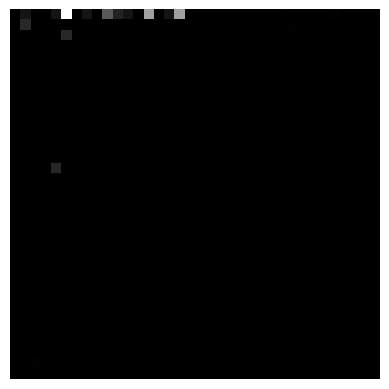

In [ ]:
for X,Y in train_loader:
  print(X.shape)
  print(Y.shape)
  break

m = batch_binary_vectors_to_gray_images(X, image_size=36)
print(m.shape)

plt.imshow(m[2], cmap='gray')
plt.axis('off')
plt.show()

(256, 36, 36)


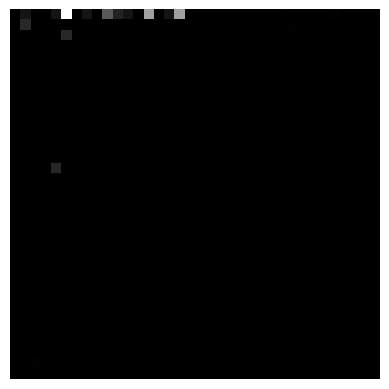

In [ ]:
a = torch.zeros(256, 10368, dtype=torch.int)
a[:,:10000] =  X

m = batch_binary_vectors_to_gray_images(a, image_size=36)
print(m.shape)

plt.imshow(m[2], cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)  # Change input channels from 1 to 2
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1, stride=2)
        self.conv3 = nn.Conv2d(64, 64, 3, padding=1, stride=2)
        self.fc1 = nn.Linear(64 * 9 * 9, 64)
        self.fc2 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.unsqueeze(1)
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.relu(self.conv3(x))
        x = torch.flatten(x, 1)
        x = nn.functional.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import LambdaLR
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

# Define a learning rate warm-up and decay function
def lr_lambda(epoch):
    if epoch < warmup_epochs:
        return float(epoch+1) / float(max(1, warmup_epochs))
    else:
        return lr_decay ** (epoch - warmup_epochs)

# Define warm-up epochs, learning rate decay factor, and other hyperparameters
warmup_epochs = 5
lr_decay = 0.97
initial_lr = 0.001

# Create an instance of the model and move it to the GPU
model = CNN().to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=initial_lr)

# Create a learning rate scheduler
scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)

# Initialize variables to track best F1 score and corresponding model state
best_f1_score = 0.0
best_model_state = None

# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for X_train, labels_train in train_loader:
        labels_train = labels_train.to(device)
        images_train = torch.tensor(batch_binary_vectors_to_gray_images(X_train, image_size=36), device=device) / 255.0
        optimizer.zero_grad()
        outputs_train = model(images_train)
        loss_train = criterion(outputs_train.squeeze(), labels_train.squeeze())
        loss_train.backward()
        optimizer.step()

        running_loss += loss_train.item()

        # Calculate training accuracy
        predicted_train = torch.round(outputs_train.squeeze())
        total_train += labels_train.size(0)
        correct_train += (predicted_train == labels_train.squeeze()).sum().item()

    train_accuracy = 100 * correct_train / total_train
    avg_loss = running_loss / len(train_loader)

    print('-----------------------------------------------------')
    print('Learning raet : ',optimizer.param_groups[0]['lr'])
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")

    # Step the learning rate scheduler
    scheduler.step()

    # Evaluate the model on the validation dataset
    model.eval()
    true_labels_val = []
    predicted_labels_val = []
    with torch.no_grad():
        for X_val, labels_val in val_loader:
            labels_val = labels_val.to(device)
            val_images = torch.tensor(batch_binary_vectors_to_gray_images(X_val, image_size=36), device=device) / 255.0
            val_outputs = model(val_images)
            predicted_val = torch.round(val_outputs.squeeze())

            # Append true and predicted labels to the lists
            true_labels_val.extend(labels_val.squeeze().tolist())
            predicted_labels_val.extend(predicted_val.tolist())

    # Convert the lists to numpy arrays
    true_labels_val = np.array(true_labels_val)
    predicted_labels_val = np.array(predicted_labels_val)

    # Compute precision, recall, and F1 score for validation set
    precision_val = precision_score(true_labels_val, predicted_labels_val)
    recall_val = recall_score(true_labels_val, predicted_labels_val)
    f1_val = f1_score(true_labels_val, predicted_labels_val)

    print(f"Validation Precision: {precision_val:.4f}, Recall: {recall_val:.4f}, F1 Score: {f1_val:.4f}")

    # Evaluate the model on the test dataset
    true_labels_test = []
    predicted_labels_test = []
    with torch.no_grad():
        for X_test, labels_test in test_loader:
            labels_test = labels_test.to(device)
            test_images = torch.tensor(batch_binary_vectors_to_gray_images(X_test, image_size=36), device=device) / 255.0
            test_outputs = model(test_images)
            predicted_test = torch.round(test_outputs.squeeze())

            # Append true and predicted labels to the lists
            true_labels_test.extend(labels_test.squeeze().tolist())
            predicted_labels_test.extend(predicted_test.tolist())

    # Convert the lists to numpy arrays
    true_labels_test = np.array(true_labels_test)
    predicted_labels_test = np.array(predicted_labels_test)

    # Compute precision, recall, and F1 score for test set
    precision_test = precision_score(true_labels_test, predicted_labels_test)
    recall_test = recall_score(true_labels_test, predicted_labels_test)
    f1_test = f1_score(true_labels_test, predicted_labels_test)

    print(f"Test Precision: {precision_test:.4f}, Recall: {recall_test:.4f}, F1 Score: {f1_test:.4f}")

    # Check if the current model has the best F1 score
    if f1_val > best_f1_score:
        best_f1_score = f1_val
        best_model_state = model.state_dict()

# Save the best model based on F1


In [ ]:
# Load the best model
best_model_state = torch.load('best_model.pth')
model = CNN()
model.load_state_dict(best_model_state)
model.eval()

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Initialize test metrics
true_labels_test = []
predicted_labels_test = []

# Perform testing
with torch.no_grad():
    for X_test, labels_test in test_loader:
        labels_test = labels_test.to(device)
        test_images = torch.tensor(batch_binary_vectors_to_gray_images(X_test, image_size=36),device=device) / 255.0
        test_outputs = model(test_images)
        predicted_test = torch.round(test_outputs.squeeze())

        # Append true and predicted labels to the lists
        true_labels_test.extend(labels_test.squeeze().tolist())
        predicted_labels_test.extend(predicted_test.tolist())

# Convert the lists to numpy arrays
true_labels_test = np.array(true_labels_test)
predicted_labels_test = np.array(predicted_labels_test)

# Compute precision, recall, and F1 score for test set
precision_test = precision_score(true_labels_test, predicted_labels_test)
recall_test = recall_score(true_labels_test, predicted_labels_test)
f1_test = f1_score(true_labels_test, predicted_labels_test)

print(f"Test Precision: {precision_test:.4f}, Recall: {recall_test:.4f}, F1 Score: {f1_test:.4f}")


Test Precision: 0.9521, Recall: 0.8408, F1 Score: 0.8930
